# Mental Health Diagnosis & Treatment Analysis
This project analyzes mental health patient data to explore relationships between diagnosis, medication, therapy, and treatment outcomes using logistic regression models.

## Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
import warnings
pd.set_option('display.expand_frame_repr', False)  # keep everything on one line
warnings.filterwarnings('ignore')

## Read in data and EDA 

In [2]:
df = pd.read_csv("/Users/emudr/Desktop/data/mental_health_diagnosis_treatment_.csv")
print(df.describe().head(5))
print(df.info())
print(df.isna().sum())
print(df.duplicated().sum())
## No nulls, no duplicated, no outliers 

       Patient ID         Age  Symptom Severity (1-10)  Mood Score (1-10)  Sleep Quality (1-10)  Physical Activity (hrs/week)  Treatment Duration (weeks)  Stress Level (1-10)  Treatment Progress (1-10)  Adherence to Treatment (%)
count  500.000000  500.000000               500.000000         500.000000            500.000000                    500.000000                  500.000000           500.000000                 500.000000                   500.00000
mean   250.500000   38.708000                 7.478000           5.482000              6.472000                      5.216000                   12.110000             7.542000                   7.436000                    75.45400
std    144.481833   12.712433                 1.706265           1.707486              1.668167                      2.829374                    2.440864             1.709409                   1.725067                     9.08697
min      1.000000   18.000000                 5.000000           3.000000       

## Data Viz

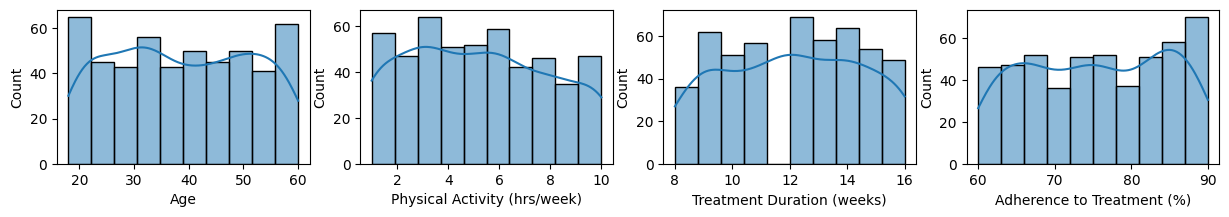

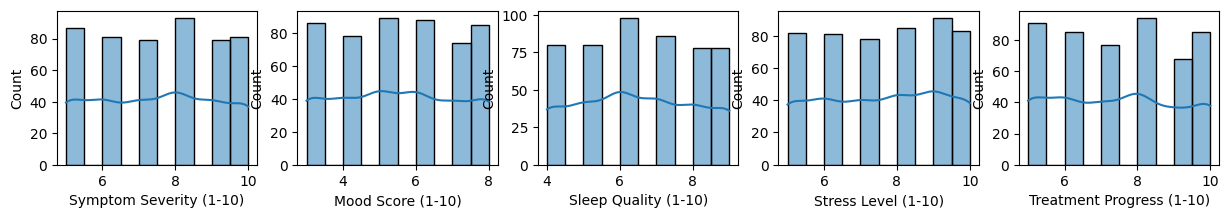

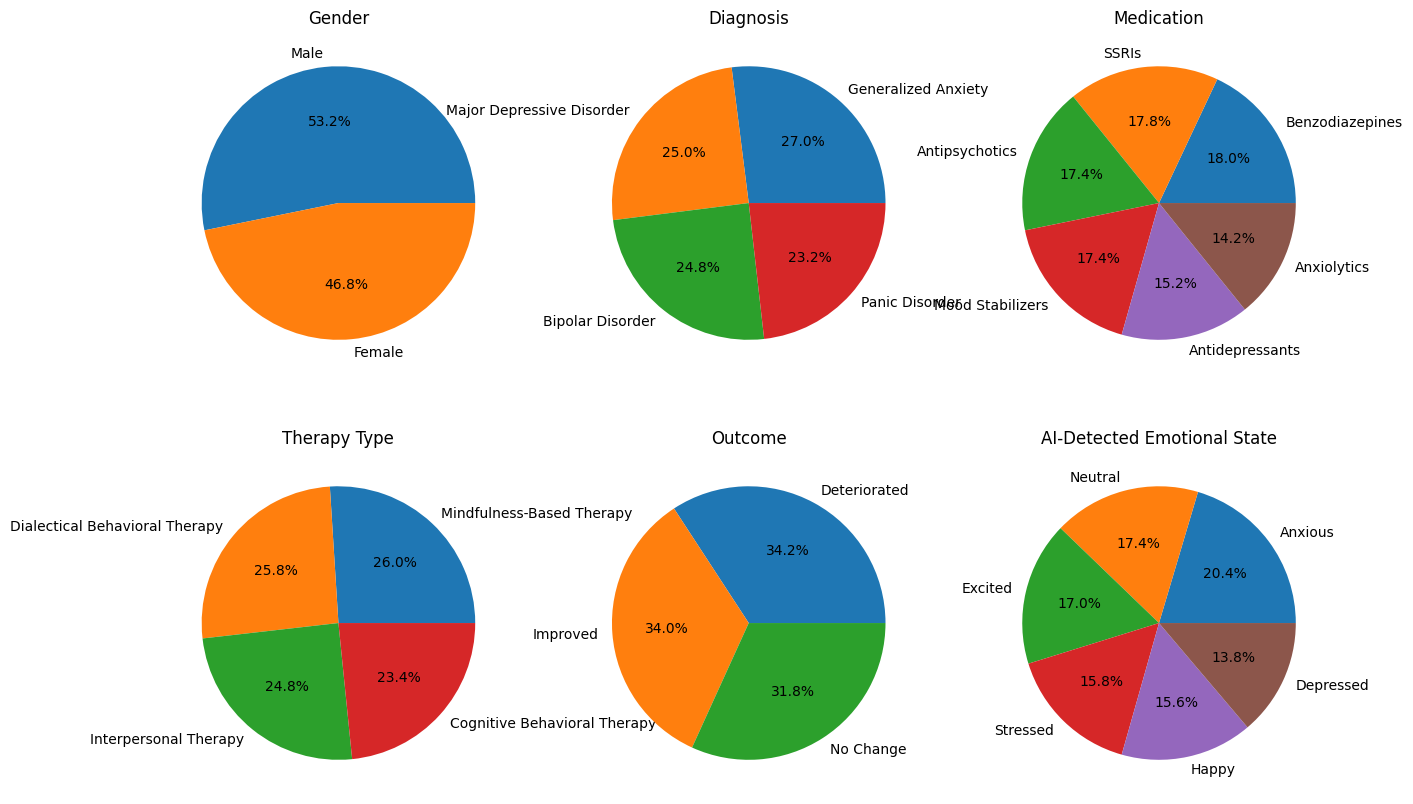

Text(0.5, 1.0, 'Correlation Matrix')

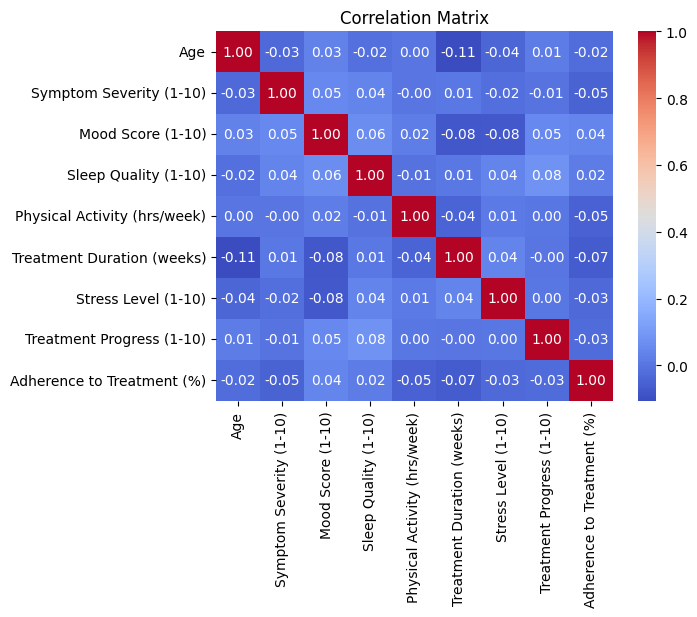

In [3]:
numeric_vars = ['Age', 'Physical Activity (hrs/week)', 'Treatment Duration (weeks)', 'Adherence to Treatment (%)']
ordinal_vars = ['Symptom Severity (1-10)', 'Mood Score (1-10)', 'Sleep Quality (1-10)', 'Stress Level (1-10)', 'Treatment Progress (1-10)']
categorical_vars = ['Gender', 'Diagnosis', 'Medication', 'Therapy Type', 'Outcome', 'AI-Detected Emotional State']

# Hist plots 
fig, axs = plt.subplots(1,4, figsize=(15,2)) 
axs = axs.flatten()
for i, col in enumerate(numeric_vars) : 
    sns.histplot(df[col], ax=axs[i], kde = True)
    axs[i].set_xlabel(col)
plt.show()

# Hist plots 
fig, axs = plt.subplots(1,5, figsize=(15,2))
axs = axs.flatten()
for i, col in enumerate(ordinal_vars): 
    sns.histplot(df[col], ax = axs[i], kde = True)
    axs[i].set_xlabel(col)
plt.show()

# Pie charts
fig, axs = plt.subplots(2,3, figsize = (15,10))
axs = axs.flatten()
for i, col in enumerate(categorical_vars):
    value_counts = df[col].value_counts(dropna=False)
    axs[i].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
    axs[i].set_title(col)
plt.show()

# Correlation matrix
df.drop(columns = ['Patient ID'], inplace = True)
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm").set_title("Correlation Matrix")

## Explore the effect of medcication and therapy for each disorder using Logistic Regression

Major Depressive Disorder


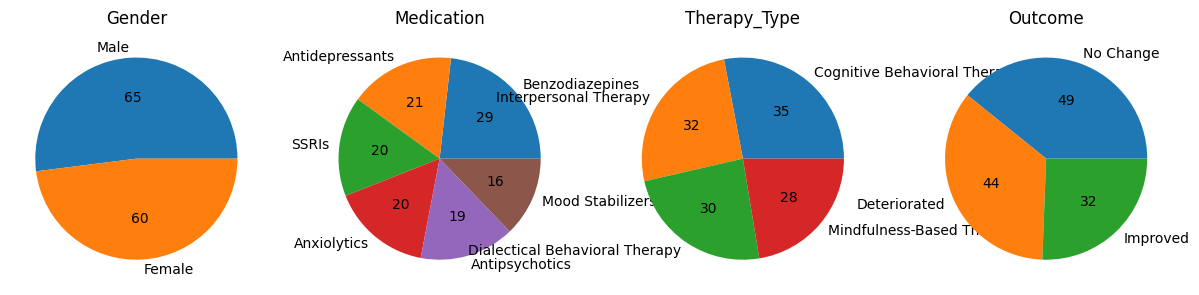

                                              columns  coefs
20  Medication[T.Antipsychotics]:Therapy_Type[T.Mi...   0.55
2                           Medication[T.Anxiolytics]   0.47
13  Medication[T.Mood Stabilizers]:Therapy_Type[T....   0.41
14  Medication[T.SSRIs]:Therapy_Type[T.Dialectical...   0.41
3                       Medication[T.Benzodiazepines]   0.39
Generalized Anxiety


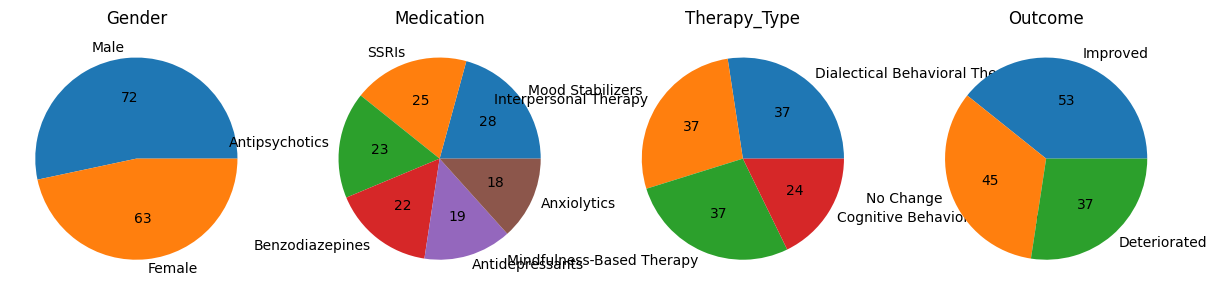

                                              columns  coefs
1                        Medication[T.Antipsychotics]   0.56
21  Medication[T.Anxiolytics]:Therapy_Type[T.Mindf...   0.56
13  Medication[T.Mood Stabilizers]:Therapy_Type[T....   0.36
12  Medication[T.Benzodiazepines]:Therapy_Type[T.D...   0.34
9                                   C(Gender)[T.Male]   0.31
Panic Disorder


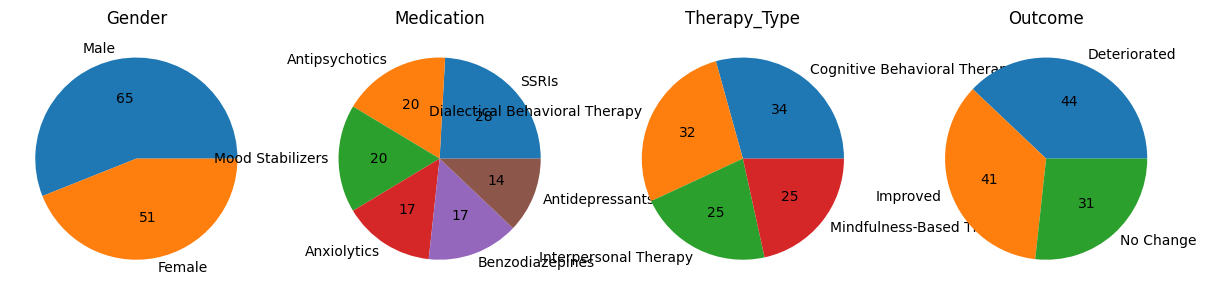

                                              columns  coefs
20  Medication[T.Antipsychotics]:Therapy_Type[T.Mi...   0.54
4                      Medication[T.Mood Stabilizers]   0.45
24  Medication[T.SSRIs]:Therapy_Type[T.Mindfulness...   0.34
14  Medication[T.SSRIs]:Therapy_Type[T.Dialectical...   0.29
5                                 Medication[T.SSRIs]   0.21
Bipolar Disorder


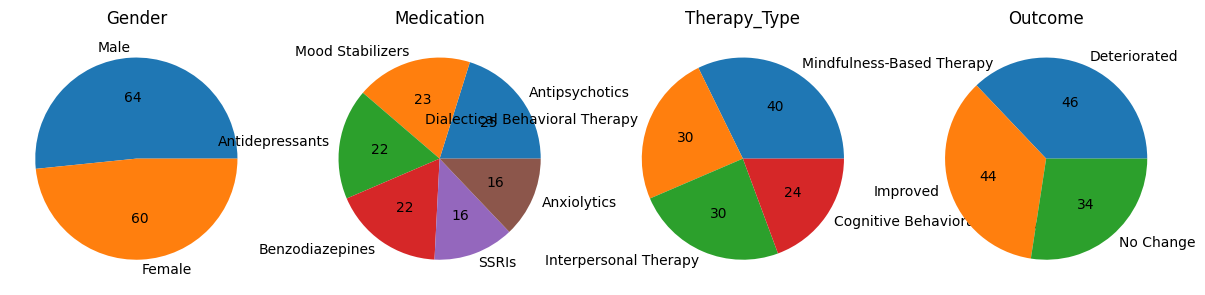

                                              columns  coefs
21  Medication[T.Anxiolytics]:Therapy_Type[T.Mindf...   0.75
10  Medication[T.Antipsychotics]:Therapy_Type[T.Di...   0.47
19  Medication[T.SSRIs]:Therapy_Type[T.Interperson...   0.45
12  Medication[T.Benzodiazepines]:Therapy_Type[T.D...   0.41
6      Therapy_Type[T.Dialectical Behavioral Therapy]   0.25


In [4]:
disorder_list = ['Major Depressive Disorder', 'Generalized Anxiety', 'Panic Disorder', 'Bipolar Disorder']

for disorder in disorder_list : 
    
    mdd = df[df['Diagnosis']==disorder]
    mdd.rename(columns = {'Therapy Type' : 'Therapy_Type'}, inplace = True)
    
    categorical_vars = ['Gender', 'Medication', 'Therapy_Type', 'Outcome']
    fig, axs = plt.subplots(1,4, figsize = (15,10))
    axs = axs.flatten()
    for i, col in enumerate(categorical_vars):
        value_counts = mdd[col].value_counts(dropna=False)
        axs[i].pie(value_counts, labels=value_counts.index,  autopct=lambda p: f'{int(round(p * sum(value_counts) / 100))}')
        axs[i].set_title(col)
    print(disorder)
    plt.show()
    
    
    # Convert to categorical
    mdd['Outcome'] = mdd['Outcome'].apply(lambda x: 1 if x == 'Improved' else 0)
    mdd['Medication'] = mdd['Medication'].astype('category')
    mdd['Therapy_Type'] = mdd['Therapy_Type'].astype('category')
    
    # Create design matrices
    formula = '''Outcome ~ Medication * Therapy_Type
                 + Age 
                 + Q("Symptom Severity (1-10)") 
                 + Q("Stress Level (1-10)") 
                 + Q("Sleep Quality (1-10)") 
                 + Q("Physical Activity (hrs/week)") 
                 + C(Gender)
                 + Q("Treatment Duration (weeks)") 
                 + Q("Adherence to Treatment (%)")
                 '''
    
    y, X = dmatrices(formula, data=mdd, return_type='dataframe')
    model = LogisticRegression(multi_class='multinomial', max_iter = 1000)
    model.fit(X, y["Outcome"])
    output_df = pd.DataFrame()
    output_df['columns'] = X.columns
    output_df['coefs'] = model.coef_[0].round(2)
    print(output_df.sort_values(by=['coefs'], ascending = False).head(5))

## 📊 Key Logistic Regression Findings

### Major Depressive Disorder (MDD)

| Predictor                                            | Coefficient | Interpretation                                        |
| ---------------------------------------------------|-------------|------------------------------------------------------|
| Medication[T.Antipsychotics]:Therapy_Type           | +0.55       | Strong positive association with treatment improvement |
| Medication[T.Anxiolytics]                            | +0.47       | Anxiolytics relate positively to improvement         |
| Medication[T.Mood Stabilizers]:Therapy_Type          | +0.41       | Combination with DBT therapy positively linked        |


### Generalized Anxiety Disorder (GAD)

| Predictor                                            | Coefficient | Interpretation                                        |
| ---------------------------------------------------|-------------|------------------------------------------------------|
| Medication[T.Antipsychotics]                         | +0.56       | Antipsychotics alone associate with better outcomes  |
| Medication[T.Anxiolytics]:Therapy_Type               | +0.56       | Strong positive interaction effect                    |
| Gender (Male)                                        | +0.31       | Males slightly more likely to improve                  |


### Panic Disorder

| Predictor                                            | Coefficient | Interpretation                                        |
| ---------------------------------------------------|-------------|------------------------------------------------------|
| Medication[T.Antipsychotics]:Therapy_Type           | +0.54       | Positive association with improvement                 |
| Medication[T.Mood Stabilizers]                       | +0.45       | Mood stabilizers linked to better outcomes            |
| Medication[T.SSRIs]:Therapy_Type                     | +0.34       | Positive interaction effect                            |


### Bipolar Disorder

| Predictor                                            | Coefficient | Interpretation                                        |
| ---------------------------------------------------|-------------|------------------------------------------------------|
| Medication[T.Anxiolytics]:Therapy_Type               | +0.75       | Strong positive effect for this combination           |
| Medication[T.Antipsychotics]:Therapy_Type            | +0.47       | Positive association with improvement                 |
| Therapy_Type[T.Dialectical Behavioral Therapy]       | +0.25       | DBT therapy alone positively linked                    |


## 🔍 Additional Insights

- Interaction terms (Medication * Therapy Type) often reveal stronger effects than individual predictors alone.
- Gender differences notable mainly in Generalized Anxiety.
- Longer treatment duration and adherence correlate positively with improvement.
- Therapy types like Dialectical Behavioral Therapy (DBT) have meaningful associations in bipolar disorder.

## Explore the effect of medication of each disorder using Logistic Regression

Major Depressive Disorder


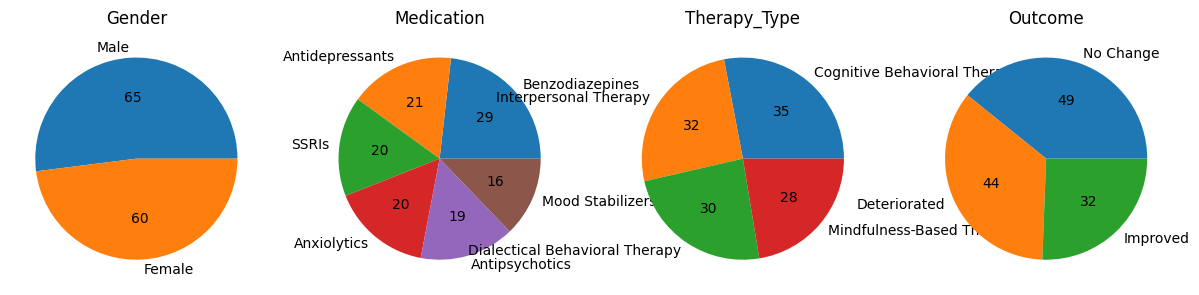

                          columns  coefs
4  Medication[T.Mood Stabilizers]   0.42
2       Medication[T.Anxiolytics]   0.29
3   Medication[T.Benzodiazepines]   0.26
Generalized Anxiety


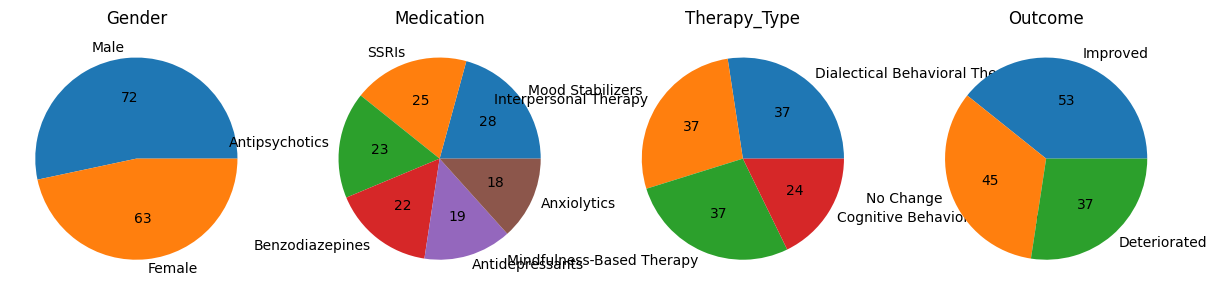

                         columns  coefs
6              C(Gender)[T.Male]   0.35
3  Medication[T.Benzodiazepines]   0.25
1   Medication[T.Antipsychotics]   0.22
Panic Disorder


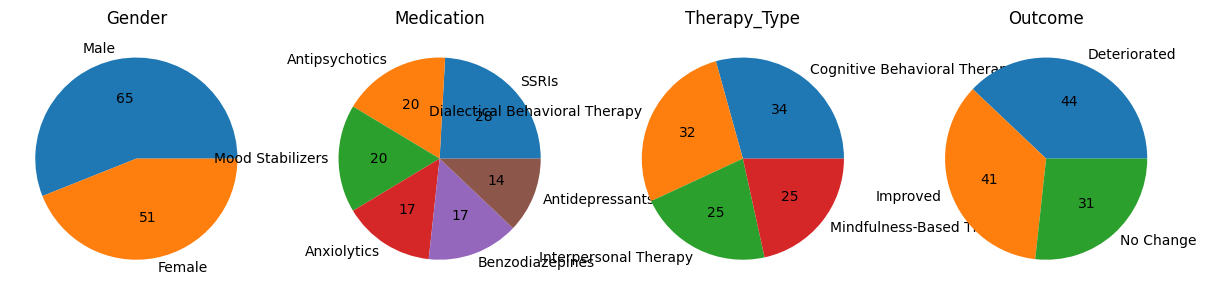

                          columns  coefs
4  Medication[T.Mood Stabilizers]   0.43
5             Medication[T.SSRIs]   0.40
3   Medication[T.Benzodiazepines]   0.09
Bipolar Disorder


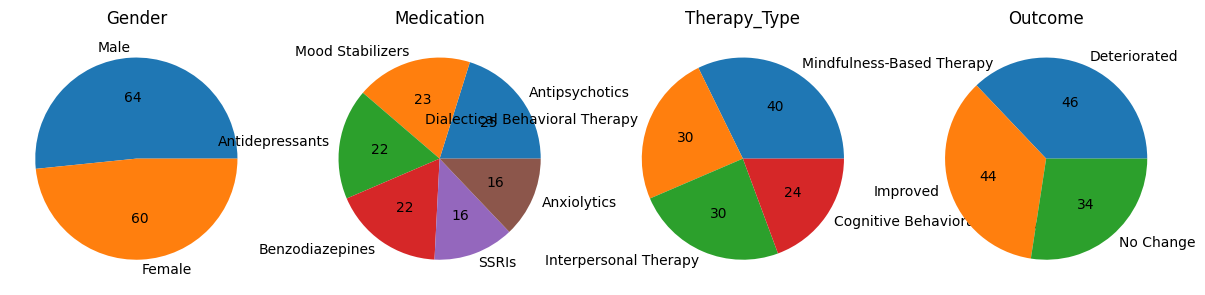

                     columns  coefs
6          C(Gender)[T.Male]   0.24
2  Medication[T.Anxiolytics]   0.06
5        Medication[T.SSRIs]   0.02


In [5]:
disorder_list = ['Major Depressive Disorder', 'Generalized Anxiety', 'Panic Disorder', 'Bipolar Disorder']

for disorder in disorder_list : 
    
    mdd = df[df['Diagnosis']==disorder]
    mdd.rename(columns = {'Therapy Type' : 'Therapy_Type'}, inplace = True)
    
    categorical_vars = ['Gender', 'Medication', 'Therapy_Type', 'Outcome']
    fig, axs = plt.subplots(1,4, figsize = (15,10))
    axs = axs.flatten()
    for i, col in enumerate(categorical_vars):
        value_counts = mdd[col].value_counts(dropna=False)
        axs[i].pie(value_counts, labels=value_counts.index,  autopct=lambda p: f'{int(round(p * sum(value_counts) / 100))}')
        axs[i].set_title(col)
    print(disorder)
    plt.show()
    
    
    # Convert to categorical
    mdd['Outcome'] = mdd['Outcome'].apply(lambda x: 1 if x == 'Improved' else 0)
    mdd['Medication'] = mdd['Medication'].astype('category')
    mdd['Therapy_Type'] = mdd['Therapy_Type'].astype('category')
    
    # Create design matrices
    formula = '''Outcome ~ Medication
                 + Age 
                 + Q("Symptom Severity (1-10)") 
                 + Q("Stress Level (1-10)") 
                 + Q("Sleep Quality (1-10)") 
                 + Q("Physical Activity (hrs/week)") 
                 + C(Gender)
                 + Q("Treatment Duration (weeks)") 
                 + Q("Adherence to Treatment (%)")
                 '''
    
    y, X = dmatrices(formula, data=mdd, return_type='dataframe')
    model = LogisticRegression(multi_class='multinomial', max_iter = 1000)
    model.fit(X, y["Outcome"])
    output_df = pd.DataFrame()
    output_df['columns'] = X.columns
    output_df['coefs'] = model.coef_[0].round(2)
    print(output_df.sort_values(by=['coefs'], ascending = False).head(3))


# 🧠 Mental Health Diagnosis - Logistic Regression Results

This report presents key findings from logistic regression models predicting mental health diagnoses based on demographic, medication, therapy, and clinical treatment variables.

## 📊 Results Set 1

### **Major Depressive Disorder (MDD)**

| Predictor                     | Coefficient | Interpretation                                                    |
|------------------------------|-------------|-------------------------------------------------------------------|
| Medication: Mood Stabilizers | **+0.42**    | Strongly associated with higher odds of MDD.                      |
| Medication: Anxiolytics      | **+0.29**    | Moderately associated with increased odds.                        |
| Medication: Benzodiazepines  | **+0.26**    | Mildly associated with increased odds.                            |

> Individuals on these medications may be experiencing more severe or comorbid symptoms.


### **Generalized Anxiety Disorder (GAD)**

| Predictor                    | Coefficient | Interpretation                                                    |
|-----------------------------|-------------|-------------------------------------------------------------------|
| Gender: Male                | **+0.35**    | Males more likely to be diagnosed with GAD.                       |
| Medication: Benzodiazepines | **+0.25**    | Commonly prescribed for anxiety, consistent with diagnosis.       |
| Medication: Antipsychotics  | **+0.22**    | Sometimes used for adjunct treatment of severe anxiety.           |

> Male gender and sedative/antipsychotic medications are linked to increased GAD likelihood.


### **Panic Disorder**

| Predictor                     | Coefficient | Interpretation                                                    |
|------------------------------|-------------|-------------------------------------------------------------------|
| Medication: Mood Stabilizers | **+0.43**    | Strongest association; may reflect affective instability.         |
| Medication: SSRIs            | **+0.40**    | SSRIs are a first-line treatment for panic disorder.              |
| Medication: Benzodiazepines  | **+0.09**    | Mildly associated with panic treatment.                           |

> Panic disorder is most strongly linked to mood stabilizers and SSRIs.


### **Bipolar Disorder**

| Predictor                | Coefficient | Interpretation                                                    |
|-------------------------|-------------|-------------------------------------------------------------------|
| Gender: Male            | **+0.24**    | Slightly more likely among males.                                |
| Medication: Anxiolytics | **+0.06**    | Weakly associated.                                               |
| Medication: SSRIs       | **+0.02**    | Minimal association; SSRIs are used cautiously in bipolar cases. |

> Gender appears to play a modest role; medication effects are weak.


## Explore the effect of therapy on each disorder

Major Depressive Disorder


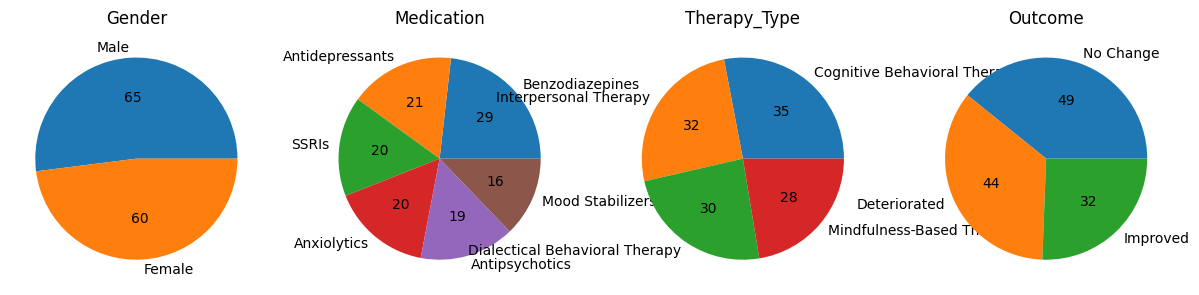

                            columns  coefs
10  Q("Treatment Duration (weeks)")   0.03
Generalized Anxiety


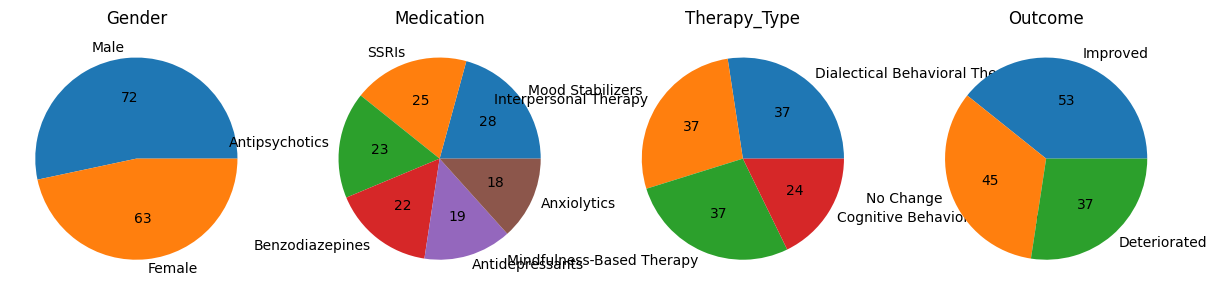

             columns  coefs
4  C(Gender)[T.Male]   0.29
Panic Disorder


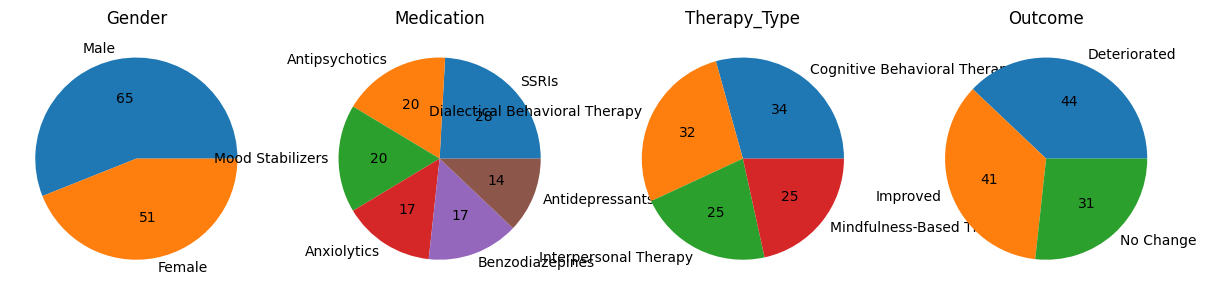

                     columns  coefs
8  Q("Sleep Quality (1-10)")   0.11
Bipolar Disorder


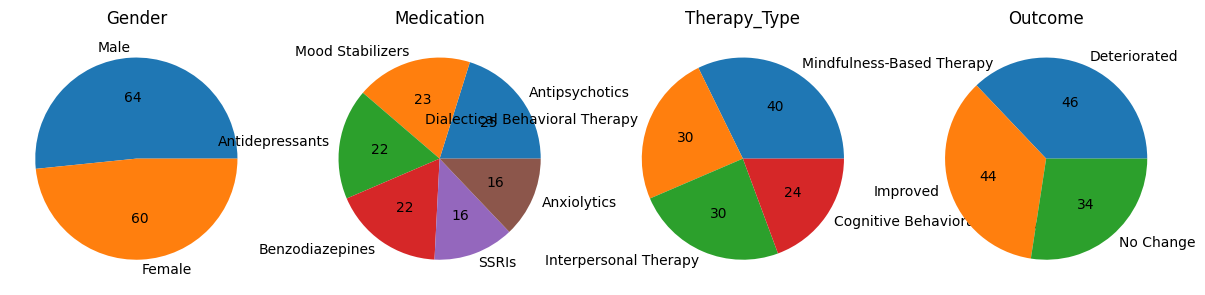

                                          columns  coefs
1  Therapy_Type[T.Dialectical Behavioral Therapy]   0.26


In [6]:
disorder_list = ['Major Depressive Disorder', 'Generalized Anxiety', 'Panic Disorder', 'Bipolar Disorder']

for disorder in disorder_list : 
    
    mdd = df[df['Diagnosis']==disorder]
    mdd.rename(columns = {'Therapy Type' : 'Therapy_Type'}, inplace = True)
    
    categorical_vars = ['Gender', 'Medication', 'Therapy_Type', 'Outcome']
    fig, axs = plt.subplots(1,4, figsize = (15,10))
    axs = axs.flatten()
    for i, col in enumerate(categorical_vars):
        value_counts = mdd[col].value_counts(dropna=False)
        axs[i].pie(value_counts, labels=value_counts.index,  autopct=lambda p: f'{int(round(p * sum(value_counts) / 100))}')
        axs[i].set_title(col)
    print(disorder)
    plt.show()
    
    
    # Convert to categorical
    mdd['Outcome'] = mdd['Outcome'].apply(lambda x: 1 if x == 'Improved' else 0)
    mdd['Medication'] = mdd['Medication'].astype('category')
    mdd['Therapy_Type'] = mdd['Therapy_Type'].astype('category')
    
    # Create design matrices
    formula = '''Outcome ~ Therapy_Type
                 + Age 
                 + Q("Symptom Severity (1-10)") 
                 + Q("Stress Level (1-10)") 
                 + Q("Sleep Quality (1-10)") 
                 + Q("Physical Activity (hrs/week)") 
                 + C(Gender)
                 + Q("Treatment Duration (weeks)") 
                 + Q("Adherence to Treatment (%)")
                 '''
    
    y, X = dmatrices(formula, data=mdd, return_type='dataframe')
    model = LogisticRegression(multi_class='multinomial', max_iter = 1000)
    model.fit(X, y["Outcome"])
    output_df = pd.DataFrame()
    output_df['columns'] = X.columns
    output_df['coefs'] = model.coef_[0].round(2)
    print(output_df.sort_values(by=['coefs'], ascending = False).head(1))


## 📊 Results Set 2

### **Major Depressive Disorder (MDD)**

| Predictor                   | Coefficient | Interpretation                                                    |
|----------------------------|-------------|-------------------------------------------------------------------|
| Treatment Duration (weeks) | **+0.03**    | Longer treatment duration is associated with higher odds of MDD.  |

> Suggests that MDD patients typically undergo longer therapeutic treatment.


### **Generalized Anxiety Disorder (GAD)**

| Predictor    | Coefficient | Interpretation                                      |
|--------------|-------------|-----------------------------------------------------|
| Gender: Male | **+0.29**    | Men moderately more likely to be diagnosed with GAD. |

> This finding may reflect sample-specific differences.


### **Panic Disorder**

| Predictor            | Coefficient | Interpretation                                                              |
|----------------------|-------------|-----------------------------------------------------------------------------|
| Sleep Quality (1–10) | **+0.11**    | Surprisingly, higher sleep quality is associated with greater odds of panic disorder. |

> May reflect non-linear effects, misreporting, or spurious correlation.

### **Bipolar Disorder**

| Predictor                                     | Coefficient | Interpretation                                                    |
|----------------------------------------------|-------------|-------------------------------------------------------------------|
| Therapy Type: Dialectical Behavioral Therapy | **+0.26**    | DBT users are more likely to be diagnosed with bipolar disorder.  |

> DBT is often used for emotional regulation, aligning with this trend.
